#Notebook Setup

In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as k
import tensorflow_hub as hub
import tensorflow_text as text
import typing

import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

##Load cleaned dataset

In [66]:
df = pd.read_csv('/content/data_clean.csv')
df.head()

,label,text
0,0,jurong point crazy available bugis n great wor...
1,0,ok lar Joking wif u oni
2,1,free entry 2 wkly comp win FA Cup final tkts 2...
3,0,u dun early hor u c
4,0,nah I think usf live


#Tokenization & Padding

In [378]:
NUM_WORDS = 7000
BATCH_SIZE = 32

In [379]:
# Tokenization
df['text'] = df['text'].astype(str)

tokenizer = k.preprocessing.text.Tokenizer(num_words=NUM_WORDS, oov_token='oov')
tokenizer.fit_on_texts(df['text'])
df['token'] = tokenizer.texts_to_sequences(df['text'])

In [380]:
#Padding
padded = k.preprocessing.sequence.pad_sequences(
                    df['token'],
                    maxlen=None,
                    padding='post'
                    )

#Build the training set

In [381]:
x_train, x_val, y_train, y_val = train_test_split(
                    padded,
                    df['label'],
                    test_size=0.3,
                    )

In [382]:
train, val = tf.data.Dataset.from_tensor_slices(
            (x_train, y_train)), tf.data.Dataset.from_tensor_slices((x_val, y_val))

train_batch, val_batch = train.shuffle(
            len(train)).batch(BATCH_SIZE), val.shuffle(len(val)).batch(BATCH_SIZE)

# Word2Vec base model

In [383]:
import tensorflow.keras.layers as l

In [384]:
model = k.Sequential([
    l.Embedding(NUM_WORDS, 8, input_shape=[padded.shape[1],]),
    l.GlobalAveragePooling1D(),
    l.Dense(8, activation='swish'),
    l.Dropout(0.2),
    l.Dense(1, activation='sigmoid')
])


OPTIMIZER = k.optimizers.Adam(learning_rate=0.01)
model.compile(
    optimizer=OPTIMIZER,
    loss=k.losses.BinaryCrossentropy(),
    metrics=[k.metrics.BinaryAccuracy(), k.metrics.Recall(), k.metrics.Precision()],
    )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [385]:
model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_24 (Embedding)             │ (None, 73, 8)               │          56,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_24          │ (None, 8)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,081 (219.07 KB)

 Trainable params: 56,081 (219.07 KB)

 Non-trainable params: 0 (0.00 B)

#Training

In [386]:
def scheduler(epoch, lr):
    lr = lr * np.exp(-0.1)
    return lr
lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = model.fit(train_batch, validation_data=val_batch, epochs=50, callbacks=[lr])

Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - binary_accuracy: 0.8428 - loss: 0.3958 - precision_24: 0.2414 - recall_24: 0.0647 - val_binary_accuracy: 0.8684 - val_loss: 0.3197 - val_precision_24: 0.0000e+00 - val_recall_24: 0.0000e+00 - learning_rate: 0.0090
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8653 - loss: 0.3159 - precision_24: 0.4810 - recall_24: 0.0279 - val_binary_accuracy: 0.9641 - val_loss: 0.1664 - val_precision_24: 0.9702 - val_recall_24: 0.7477 - learning_rate: 0.0082
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.9605 - loss: 0.1365 - precision_24: 0.9831 - recall_24: 0.7261 - val_binary_accuracy: 0.9815 - val_loss: 0.1117 - val_precision_24: 0.9431 - val_recall_24: 0.9128 - learning_rate: 0.0074
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.9782 - loss: 0.0862 - precision_24: 0.9737 - recall_24: 0.8595 - val_binary_accuracy: 0.9833 - val_loss: 0.0596 - val_precision_24: 0.9703 

In [396]:
model.evaluate(val_batch)

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.9871 - loss: 0.0518 - precision_24: 1.0000 - recall_24: 0.9076


[0.04650168493390083, 0.989234447479248, 0.9174311757087708, 1.0]

#Evaluation

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1454
           1       1.00      0.92      0.96       218

    accuracy                           0.99      1672
   macro avg       0.99      0.96      0.98      1672
weighted avg       0.99      0.99      0.99      1672



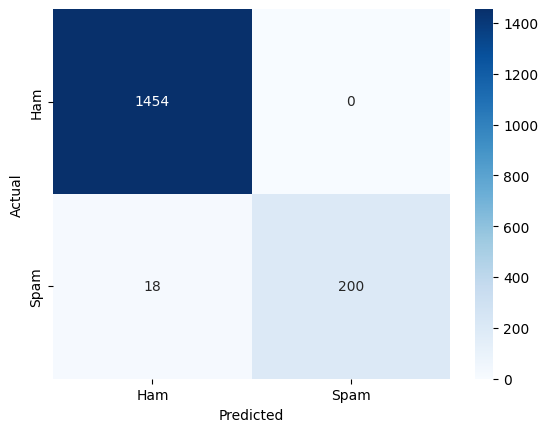

In [388]:
# Evaluation
def evaluate_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred = np.where(y_pred < 0.5, 0, 1)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model(model, x_val, y_val)

##Let's redefine a preprocessing function to test model with new a message

In [389]:
import re
import spacy
nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS

In [391]:
def preprocess_text(text):
  text = re.sub(r'[^a-zA-Z0-9 ]','',text.strip())
  return ' '.join([token.lemma_ for token in nlp(text) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)])

##Let's test our model

In [392]:
# Single Message Prediction
def predict_spam(model, text):
    processed_text = tokenizer.texts_to_sequences([preprocess_text(text)])
    padded_text = k.preprocessing.sequence.pad_sequences(processed_text, maxlen=100, padding='post')
    pred = model.predict(padded_text)[0][0]
    return "Spam" if pred > 0.5 else "Ham"

##Examples

In [393]:
# SPAM Message
sample_text = "Congratulations! You’ve won a $500 Amazon gift card. Claim it here "
print("Prediction:", predict_spam(model, sample_text))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Prediction: Spam


In [394]:
# NOT a SPAM Message
sample_text = "The dog is in the garden. "
print("Prediction:", predict_spam(model, sample_text))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction: Ham
